# Diabetes predictions:

## MLflow setup:

In [38]:
import mlflow
from mlflow.models.signature import infer_signature

In [39]:
MLFLOW_TRACKING_URI = "http://localhost:5000"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# mlflow.sklearn.autolog()

## Import Libraries & Load Dataset:

In [125]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
%cd ..

/home/tiennk/mle_m1/Diabetes-Prediction


In [41]:
import pandas as pd
datapath = "./data/raw_data/diabetes.csv"
df = pd.read_csv(datapath)
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


## Problem Description:
This dataset is comprised of 8 input variables that describe medical details of patients and one output variable to indicate whether the patient will have an onset of diabetes within 5 years

source: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

We might infer the target column is "Outcome" and the rest are the feature columns.

Pregnancies: Number of pregnancies

Glucose: 2-hour plasma glucose concentration during an oral glucose tolerance test

Blood Pressure: Blood Pressure (Diastolic)(mm Hg)

SkinThickness : Thickness of skin

Insulin: 2-Hour Serum Insulin (mu U/ml)

DiabetesPedigreeFunction: Function (2-hour plasma glucose concentration during an oral glucose tolerance test)

BMI: Body Mass Index (weight in kg/(height in meters)^2)

Age: Persons age(in years)

Outcome: Having diabetes status (1: diabetes, 0: no diabetes )

## EDA:

In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.shape

(768, 9)

In [5]:
#check type of each collumn:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.isnull().values.any()

False

we dont have any non-numeric columns and missing values!

In [ ]:
df.duplicated().sum()

0

No duplicate values also :D

In [ ]:
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [ ]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

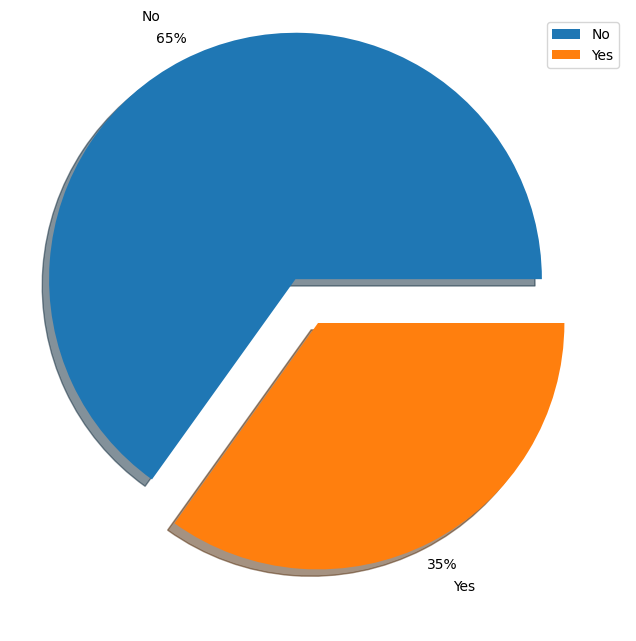

In [6]:
list_pie = list(df['Outcome'].value_counts())
temp_list = []

labels = ["No","Yes"]
for pie in list_pie:
  temp_list.append((pie/df.shape[0])*100)
myexplode = [0.2, 0]

sizes = temp_list

fig = plt.figure(figsize =(10, 8))
plt.pie(sizes, labels = labels,explode = myexplode, shadow = True,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.legend()
plt.show()

The data label is quite balanced! No need to deal with imbalanced data <3

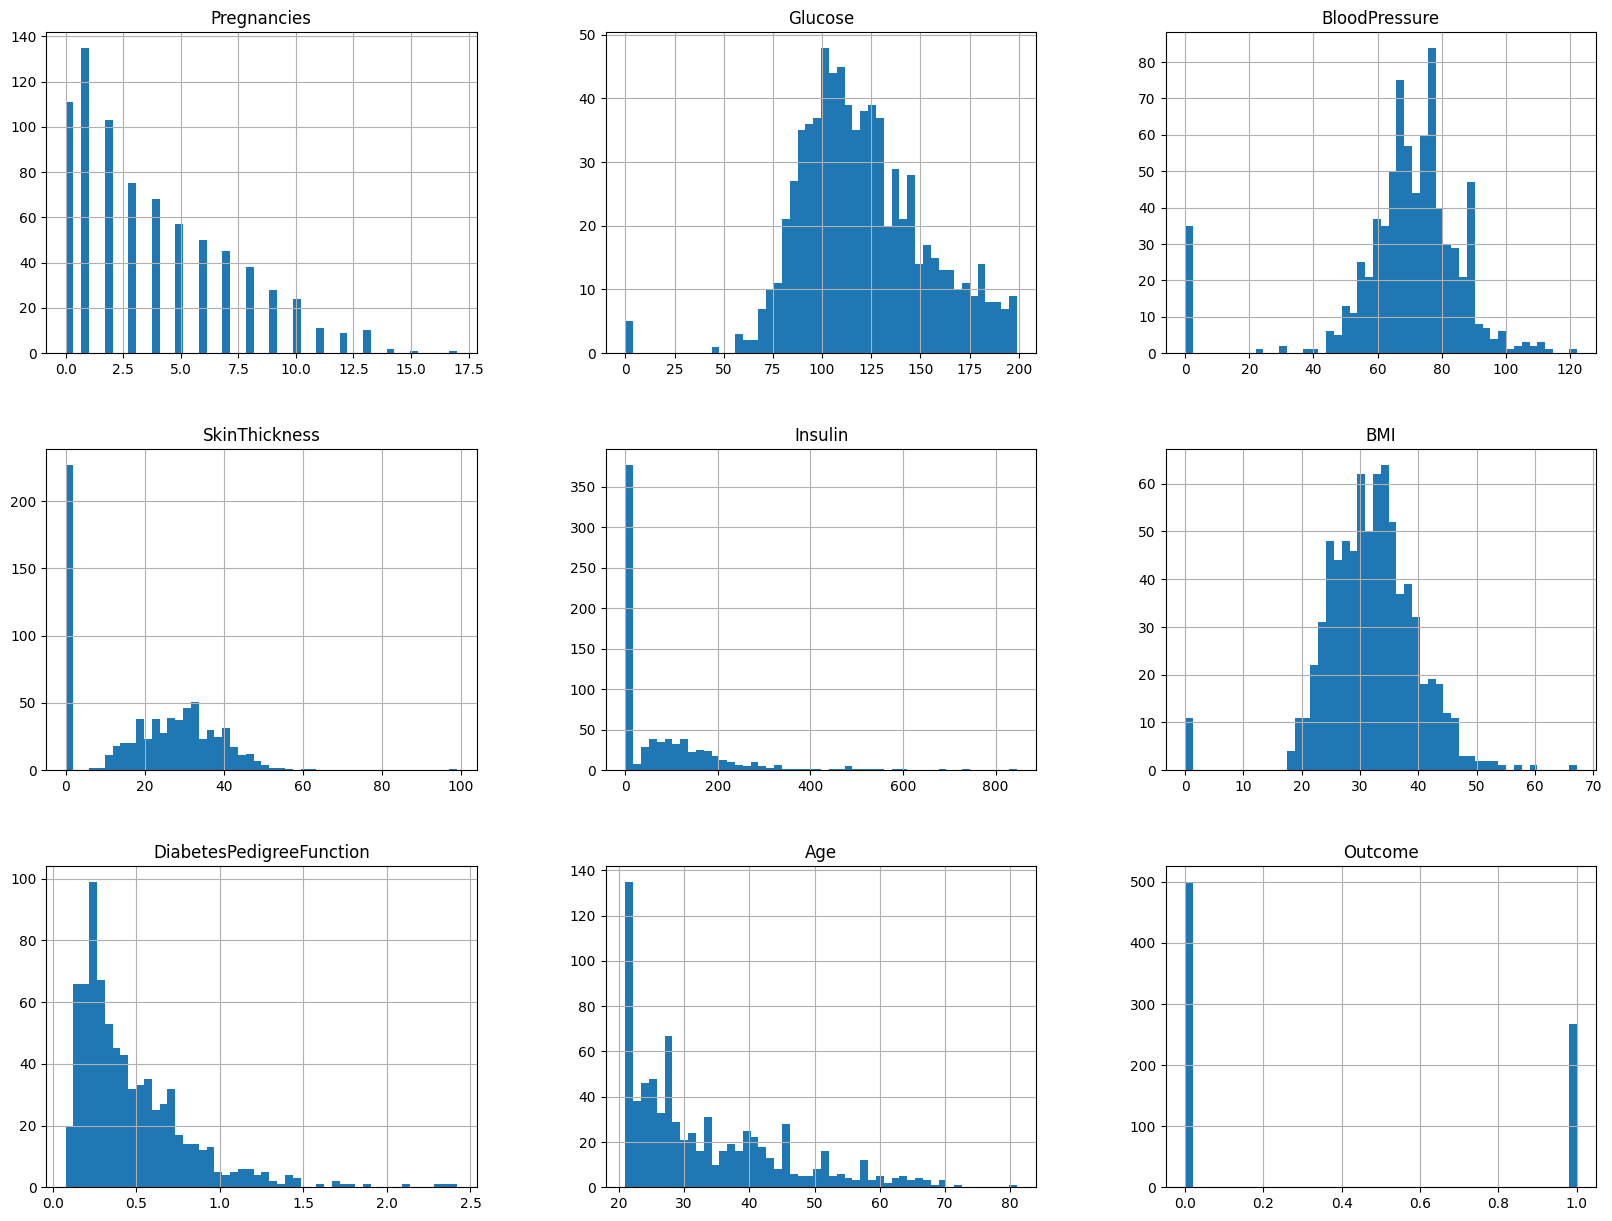

In [ ]:
%matplotlib inline

df.hist(bins=50, figsize=(20, 15));

+ The SkinThickness, Insulin and Age have higher first bins
than nearby bins, indicating that the possibility of values being clipped at those values.

+ we observed a high value of 0 in values such as Glucose, BloodPressure, SkinThickness, Insulin, and BMI in our dataset. These values cannot be 0!!! So we need replace them with other values.

+ We also have some right-tail skewed distribution in  DiabetesPedigreeFunction, Age !

+ And the presence of outliers in Insulin, BMI, BloodPressure, Pregnancies, DiabetesPedigreeFunction and Age, which may cause problems during model fitting (esp. linear models) and may also result in inflated error metrics which give higher weights to large errors.

+ Hmmm, another problem we also need to discuss is the differences in the ranges of values of numeric columns in the dataset might affect to model prediction.



<Axes: >

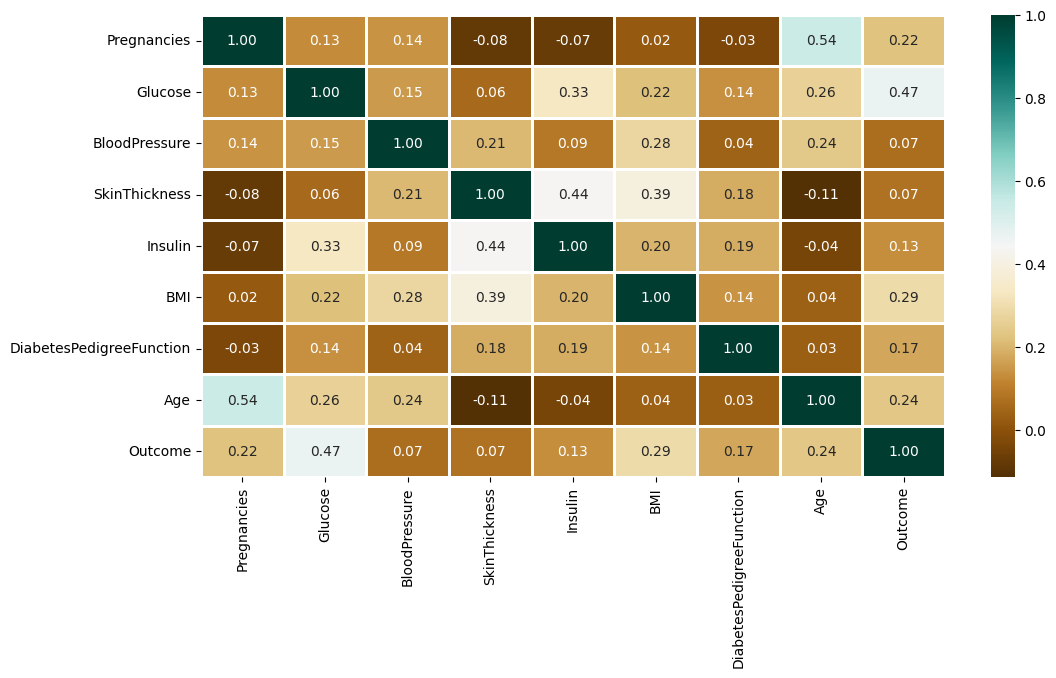

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

Obviously, we can see the label "outcome" is strongly correlated with Glusecose, BMI and Age (Glusecose being the most so)!

In generally, which are very rational considering that the more glucose one consumes, the greater their risk of diabetes!

## Preprocess Data:

In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Split train/test:

Because Glusecose feature has strongly correlated with the label, we need to ensures each subgroup within the population receives proper representation within the train set and test set also!

<Axes: >

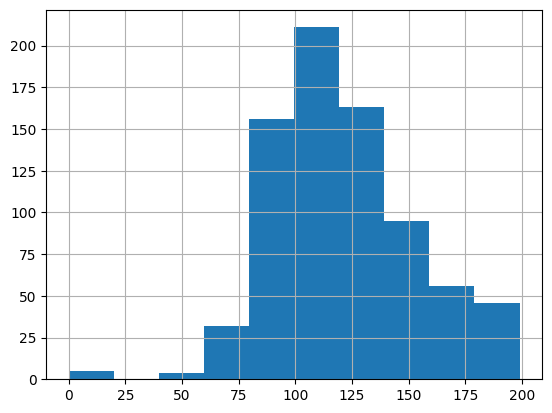

In [9]:
df["Glucose"].hist()

In [10]:
df["Glucose_cat"] = pd.cut(df["Glucose"],
                               bins=[-1,50.0, 75.0, 100.0,125.0,150.0,175.0,np.inf],
                               labels=[1, 2, 3,4,5,6,7])

<Axes: >

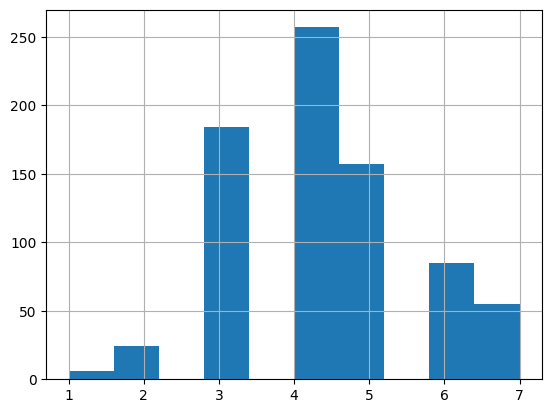

In [11]:
df["Glucose_cat"].hist()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Glucose_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Glucose_cat", axis=1, inplace=True)

In [14]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 142 to 406
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.0 KB


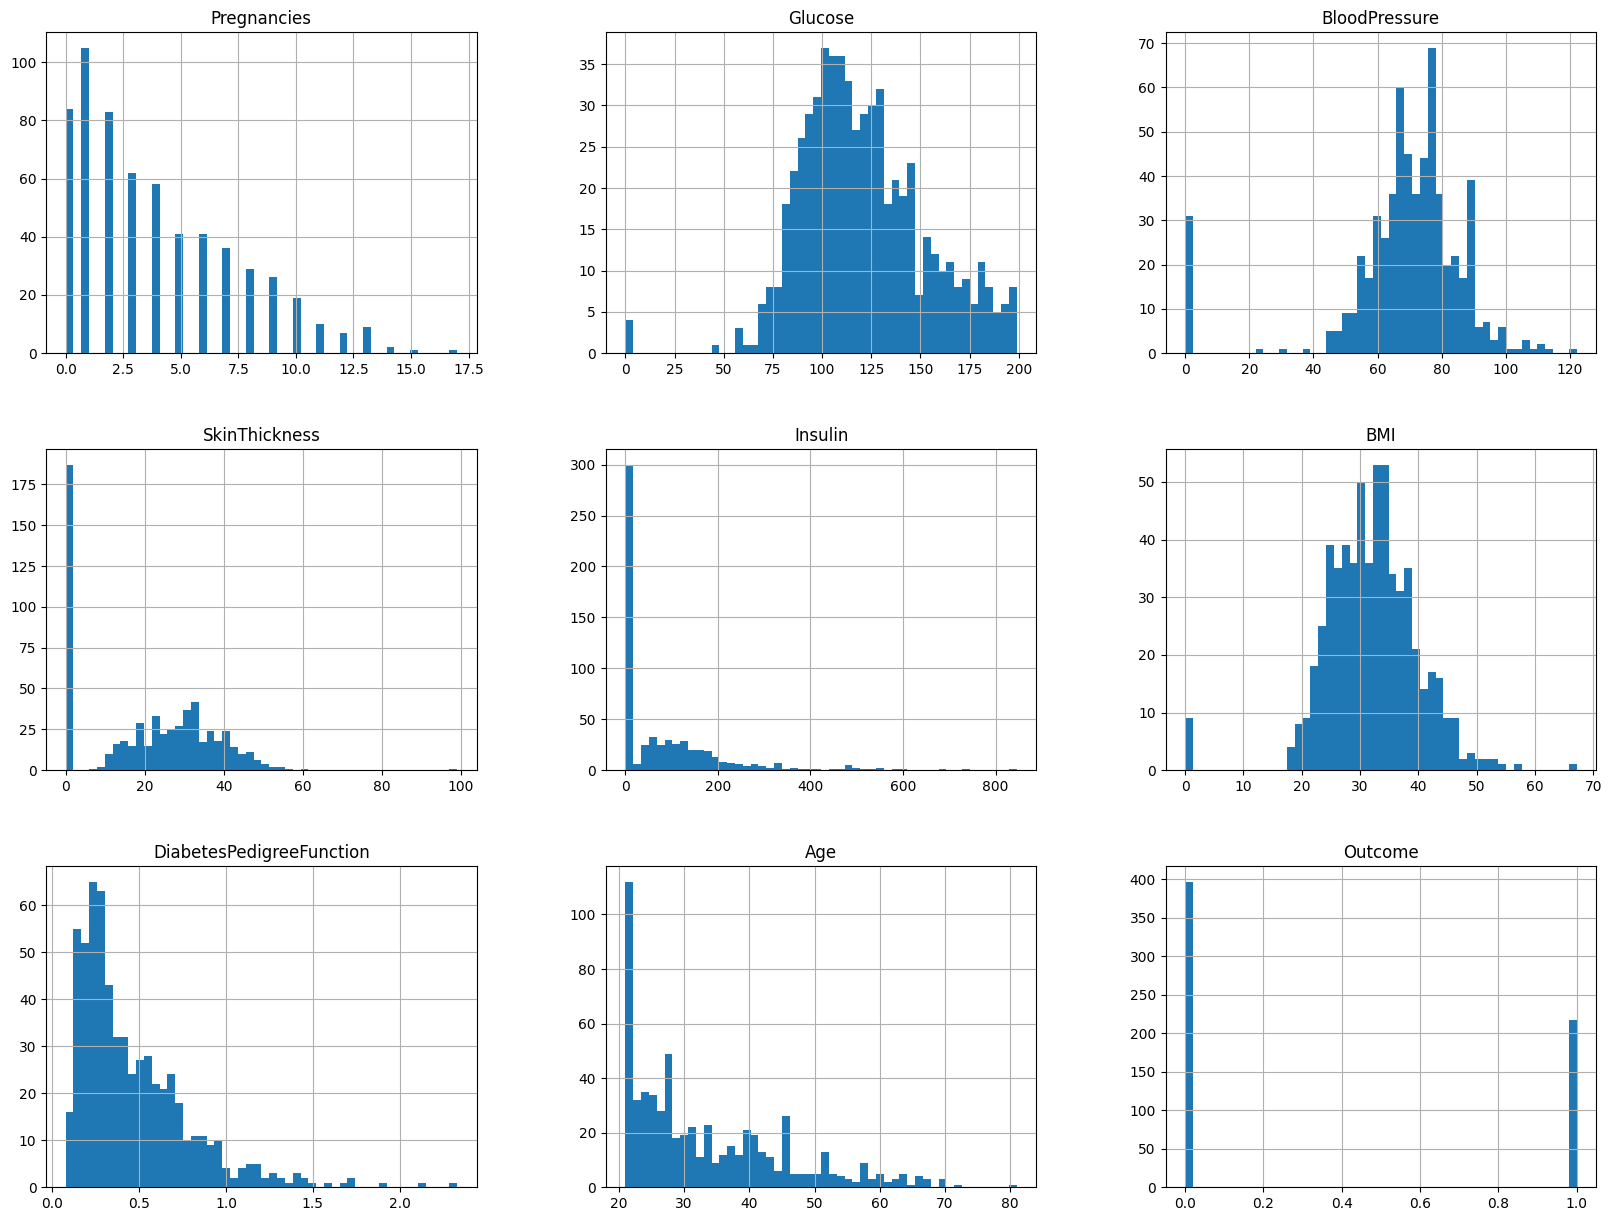

In [32]:
strat_train_set.hist(bins=50, figsize=(20, 15));

To prevent **data leakage**, put the test set away !!!


In [ ]:
X_train=strat_train_set[[i  for i in strat_train_set.columns if i != 'Outcome']]
y_train=strat_train_set[['Outcome']]
X_test=strat_test_set[[i  for i in strat_test_set.columns if i != 'Outcome']]
y_test=strat_test_set[['Outcome']]

In [45]:
train_x_path='./data/baseline_data/train_x.parquet'
train_y_path='./data/baseline_data/train_y.parquet'
test_x_path='./data/baseline_data/test_x.parquet'
test_y_path='./data/baseline_data/test_y.parquet'

In [51]:
X_train.to_parquet(train_x_path, index=False)
y_train.to_parquet(train_y_path, index=False)
X_test.to_parquet(test_x_path, index=False)
y_test.to_parquet(test_y_path, index=False)

### Experiment 1: Base-line model (without data processing):

In [93]:
X_train = pd.read_parquet(train_x_path)
y_train= pd.read_parquet(train_y_path)
X_test= pd.read_parquet(test_x_path)
y_test= pd.read_parquet(test_y_path)

In [94]:
def model_evaluation(model, X_test, y_test):
    metrics= {}

    pred = model.predict(X_test)
    acc = accuracy_score(y_test.values.ravel(), pred)
    metrics["test_accuracy"] = acc
    metrics["test_f1_score"]= f1_score(y_test.values.ravel(), pred)
    metrics["test_auc_score"]= roc_auc_score(y_test.values.ravel(), pred)

    return metrics

In [95]:
def model_log(experiment_name, run_name, model, X_test,metrics):
    mlflow.set_experiment(
    f"Diabetes_prediction_{experiment_name}")

    mlflow.set_tag("mlflow.runName", run_name)
    #mlflow log
    mlflow.log_params(model.get_params())
    mlflow.log_metrics(metrics)

    pred= model.predict(X_test)
    signature = infer_signature(X_test, pred)

    mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="model",
                signature=signature,
            )
    mlflow.end_run()

#### LogisticRegression model:

In [96]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp1-lr-model', lr, X_test,metrics)
metrics


/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `dist

{'test_accuracy': 0.7272727272727273,
 'test_f1_score': 0.5227272727272727,
 'test_auc_score': 0.6575290310298878}

#### RandomForest model:

In [97]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp1-rfc-model', rfc, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `dist

{'test_accuracy': 0.7207792207792207,
 'test_f1_score': 0.5567010309278351,
 'test_auc_score': 0.6724728726442032}

#### XGBOOST model:

In [ ]:

EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp1-xgb-model', xgb_model, X_test,metrics)
metrics

In [99]:
metrics

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6060606060606061,
 'test_auc_score': 0.7067390062821246}

### Deal with high zero values in some columns:

"we observed a high value of 0 in values such as Glucose, BloodPressure, SkinThickness, Insulin, and BMI in our dataset. These values cannot be 0!!! So we need replace them with other values."


In [100]:
X_train = pd.read_parquet(train_x_path)
y_train= pd.read_parquet(train_y_path)
X_test= pd.read_parquet(test_x_path)
y_test= pd.read_parquet(test_y_path)

In [101]:
highzero_columns = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
X_train[highzero_columns] = X_train[highzero_columns].replace(0,np.NaN)

In [102]:
#Finding the mean of the column having NaN
Glucose_mean_value=X_train['Glucose'].mean()
BloodPressure_mean_value=X_train['BloodPressure'].mean()
SkinThickness_mean_value=X_train['SkinThickness'].mean()
Insulin_mean_value=X_train['Insulin'].mean()
BMI_mean_value=X_train['BMI'].mean()


# Let's fill in the missing values with the mean of each column.
X_train['Glucose'].fillna(value=Glucose_mean_value, inplace=True)
X_train['BloodPressure'].fillna(value=BloodPressure_mean_value, inplace=True)
X_train['SkinThickness'].fillna(value=SkinThickness_mean_value, inplace=True)
X_train['Insulin'].fillna(value=Insulin_mean_value, inplace=True)
X_train['BMI'].fillna(value=BMI_mean_value, inplace=True)

In [103]:
X_train.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

source: https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/

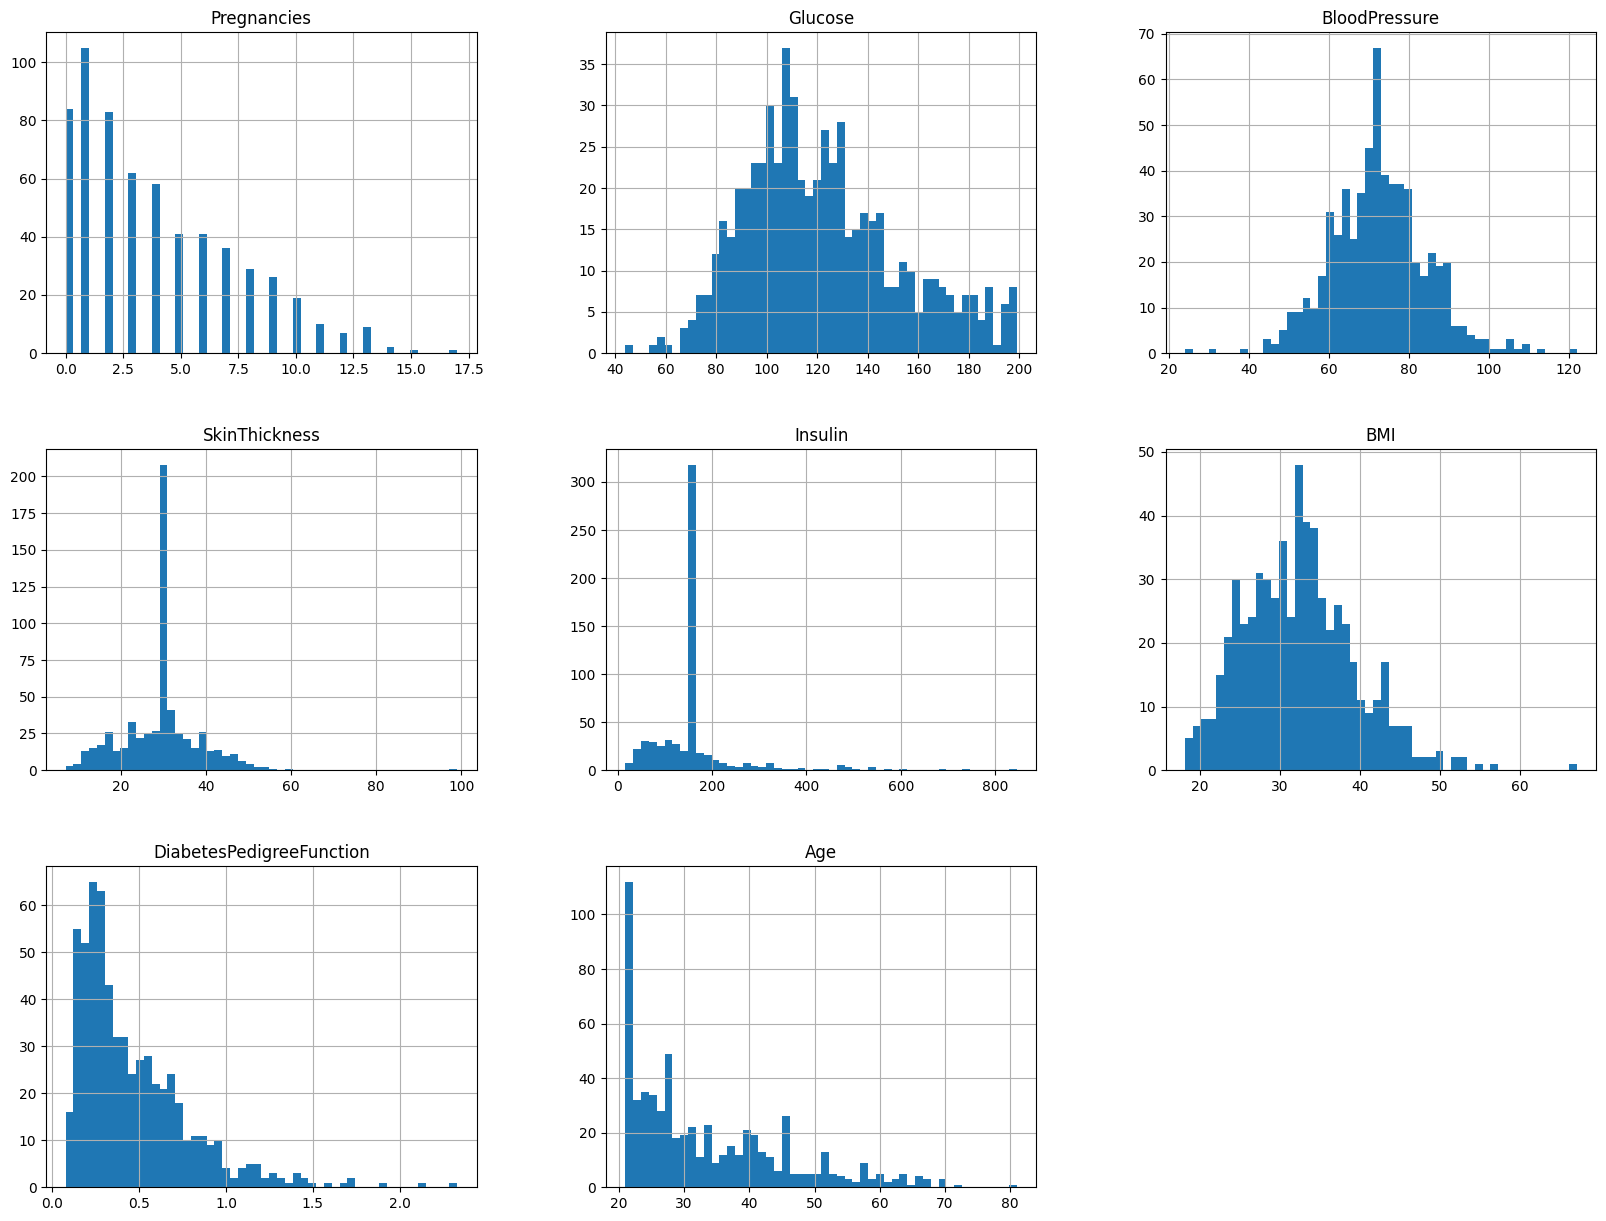

In [104]:
X_train.hist(bins=50, figsize=(20, 15));

### Remove outlier:

"And the presence of outliers in Insulin, BMI, BloodPressure, Pregnancies, DiabetesPedigreeFunction and Age, which may cause problems during model fitting (esp. linear models) and may also result in inflated error metrics which give higher weights to large errors."

In [105]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

Let's check if there are outliers according to the threshold values

In [106]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [107]:
for col in X_train.columns:
    print(col, check_outlier(X_train, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [108]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [109]:
for col in X_train.columns:
    replace_with_thresholds(X_train, col)

/tmp/ipykernel_1401737/130684917.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.025000000000034' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [110]:
for col in X_train.columns:
    print(col, check_outlier(X_train, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


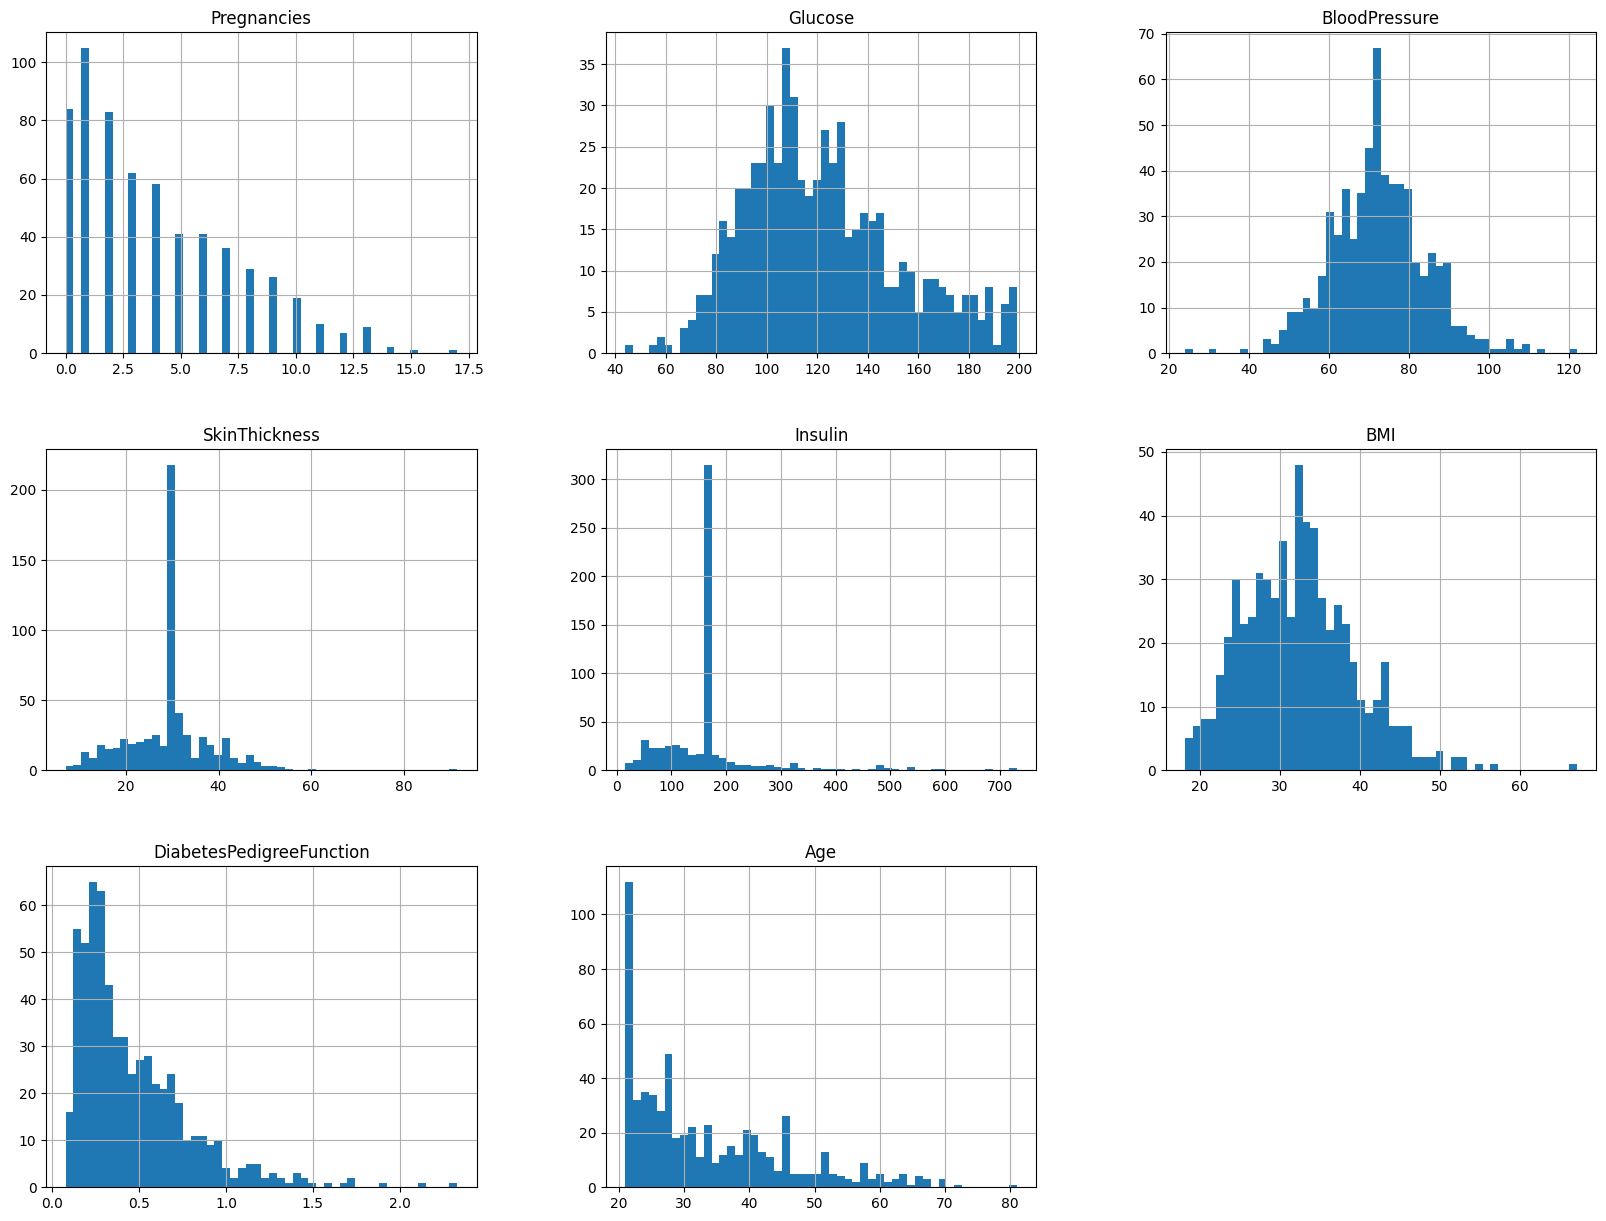

In [96]:
X_train.hist(bins=50, figsize=(20, 15));

In [111]:
cleaned_train_x_path='./data/cleaned_data/cleaned_train_x.parquet'
cleaned_train_y_path='./data/cleaned_data/cleaned_train_y.parquet'
cleaned_test_x_path='./data/cleaned_data/cleaned_test_x.parquet'
cleaned_test_y_path='./data/cleaned_data/cleaned_test_y.parquet'

In [112]:
X_train.to_parquet(cleaned_train_x_path, index=False)
y_train.to_parquet(cleaned_train_y_path, index=False)

In [113]:
# apply to X_test:
X_test[highzero_columns] = X_test[highzero_columns].replace(0,np.NaN)

# Let's fill in the missing values with the mean of each column.
X_test['Glucose'].fillna(value=Glucose_mean_value, inplace=True)
X_test['BloodPressure'].fillna(value=BloodPressure_mean_value, inplace=True)
X_test['SkinThickness'].fillna(value=SkinThickness_mean_value, inplace=True)
X_test['Insulin'].fillna(value=Insulin_mean_value, inplace=True)
X_test['BMI'].fillna(value=BMI_mean_value, inplace=True)

In [114]:
X_test.to_parquet(cleaned_test_x_path, index=False)
y_test.to_parquet(cleaned_test_y_path, index=False)

### Experiment 2: Model with cleaned data (remove outlier + replace zero value):

In [115]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

#### LogisticRegression model:

In [116]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp2-lr-model', lr, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `dist

{'test_accuracy': 0.7272727272727273,
 'test_f1_score': 0.5227272727272727,
 'test_auc_score': 0.6575290310298878}

#### RandomForest model:

In [118]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp2-rfc-model', rfc, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `dist

{'test_accuracy': 0.7142857142857143,
 'test_f1_score': 0.5599999999999999,
 'test_auc_score': 0.6725680563487532}

#### XGBoost model:

In [ ]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp2-xgb-model', xgb_model, X_test,metrics)
metrics

In [120]:
metrics

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

### Experiment 3: (cleaned_data + XGBoost model + standard scaler):

In [121]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [124]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp3-xgb-model', xgb_model, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or m

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

### Experiment 4: (cleaned_data + XGBoost model + minmaxScaler ):

In [126]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

In [127]:
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [128]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-xgb-model', xgb_model, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or m

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}

### Experiment 5: (cleaned_data + XGBoost model + LogTransformation + standardScaler  ):

In [145]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

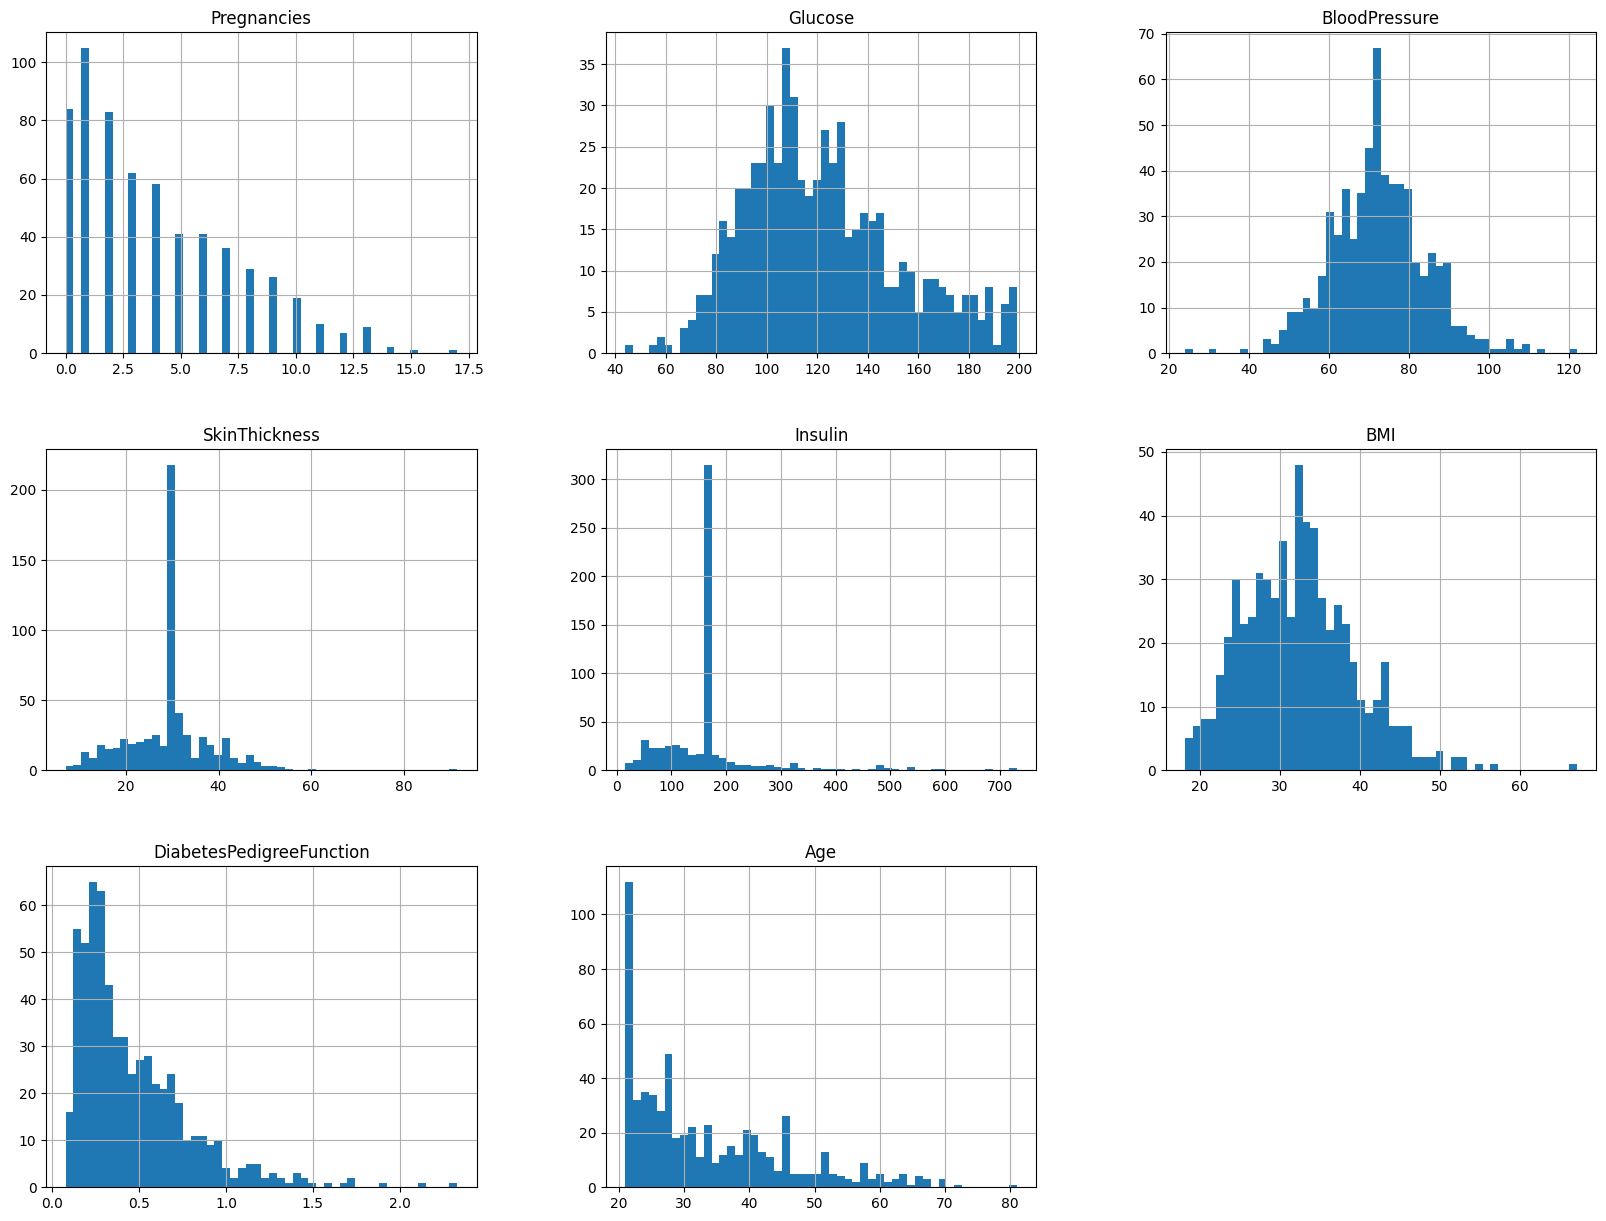

In [130]:
X_train.hist(bins=50, figsize=(20, 15));

"We also have some right-tail skewed distribution in DiabetesPedigreeFunction, Age !"

Effects of skewed data: Degrades the model’s ability (especially regression based models) to describe typical cases as it has to deal with rare cases on extreme values. ie right skewed data will predict better on data points with lower value as compared to those with higher values. Skewed data also does not work well with many statistical methods. However, tree based models are not affected.

link: https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725#:~:text=Effects%20of%20skewed%20data%3A%20Degrades,to%20those%20with%20higher%20values.

In [146]:
X_train= X_train[['DiabetesPedigreeFunction', 'Age']].apply(lambda x: np.log(x))
X_test= X_test[['DiabetesPedigreeFunction', 'Age']].apply(lambda x: np.log(x))

In [142]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [147]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp5-xgb-model', xgb_model, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a f

{'test_accuracy': 0.7077922077922078,
 'test_f1_score': 0.4943820224719101,
 'test_auc_score': 0.6380163715971826}

In [148]:
EXPERIMENT_NAME='RandomForest'
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(rfc, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-rfc-model', rfc, X_test,metrics)
metrics

{'test_accuracy': 0.6363636363636364,
 'test_f1_score': 0.4042553191489362,
 'test_auc_score': 0.5697696554349895}

In [149]:
EXPERIMENT_NAME='LogisticRegression'
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train.values.ravel())

metrics=model_evaluation(lr, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp4-lr-model', lr, X_test,metrics)
metrics

{'test_accuracy': 0.7012987012987013,
 'test_f1_score': 0.37837837837837845,
 'test_auc_score': 0.5935655815724348}

### Experiment 6: (cleaned_data + XGBoost model + PowerTransformation + standardScaler  ):

In [150]:
X_train = pd.read_parquet(cleaned_train_x_path)
y_train= pd.read_parquet(cleaned_train_y_path)
X_test= pd.read_parquet(cleaned_test_x_path)
y_test= pd.read_parquet(cleaned_test_y_path)

In [151]:
right_skewed_cols=['DiabetesPedigreeFunction', 'Age']

In [152]:
from sklearn.preprocessing import PowerTransformer
transPowerYeojohnson=PowerTransformer(method="yeo-johnson")

X_train[right_skewed_cols]=transPowerYeojohnson.fit_transform(X_train[right_skewed_cols])
X_test[right_skewed_cols]=transPowerYeojohnson.transform(X_test[right_skewed_cols])

In [153]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [154]:
EXPERIMENT_NAME='XGboost'
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

metrics=model_evaluation(xgb_model, X_test, y_test)
model_log(EXPERIMENT_NAME, 'exp6-xgb-model', xgb_model, X_test,metrics)
metrics

/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/tiennk/anaconda3/envs/Diabetes_Predictions_2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/tiennk/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or m

{'test_accuracy': 0.7467532467532467,
 'test_f1_score': 0.6355140186915887,
 'test_auc_score': 0.7265372168284789}